Using device: cuda
Classes: ['cats', 'dogs', 'serval']
Epoch [1/200], Loss: 1.1087, Accuracy: 43.24%
Epoch [2/200], Loss: 1.3043, Accuracy: 29.73%
Epoch [3/200], Loss: 1.4673, Accuracy: 37.84%
Epoch [4/200], Loss: 1.0235, Accuracy: 54.05%
Epoch [5/200], Loss: 1.1112, Accuracy: 54.05%
Epoch [6/200], Loss: 0.6804, Accuracy: 70.27%
Epoch [7/200], Loss: 0.8856, Accuracy: 56.76%
Epoch [8/200], Loss: 0.9046, Accuracy: 59.46%
Epoch [9/200], Loss: 0.7522, Accuracy: 72.97%
Epoch [10/200], Loss: 0.7743, Accuracy: 62.16%
Epoch [11/200], Loss: 0.6769, Accuracy: 72.97%
Epoch [12/200], Loss: 0.7733, Accuracy: 67.57%
Epoch [13/200], Loss: 0.9197, Accuracy: 51.35%
Epoch [14/200], Loss: 0.7130, Accuracy: 70.27%
Epoch [15/200], Loss: 0.7684, Accuracy: 59.46%
Epoch [16/200], Loss: 0.7998, Accuracy: 64.86%
Epoch [17/200], Loss: 0.6557, Accuracy: 72.97%
Epoch [18/200], Loss: 0.7951, Accuracy: 75.68%
Epoch [19/200], Loss: 0.8190, Accuracy: 59.46%
Epoch [20/200], Loss: 0.6203, Accuracy: 67.57%
Epoch [21/200]

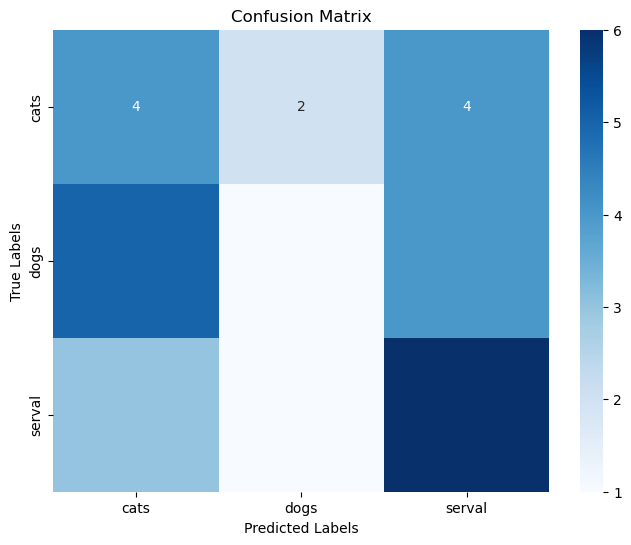


Classification Report:
               precision    recall  f1-score   support

        cats       0.33      0.40      0.36        10
        dogs       0.25      0.10      0.14        10
      serval       0.43      0.60      0.50        10

    accuracy                           0.37        30
   macro avg       0.34      0.37      0.34        30
weighted avg       0.34      0.37      0.34        30



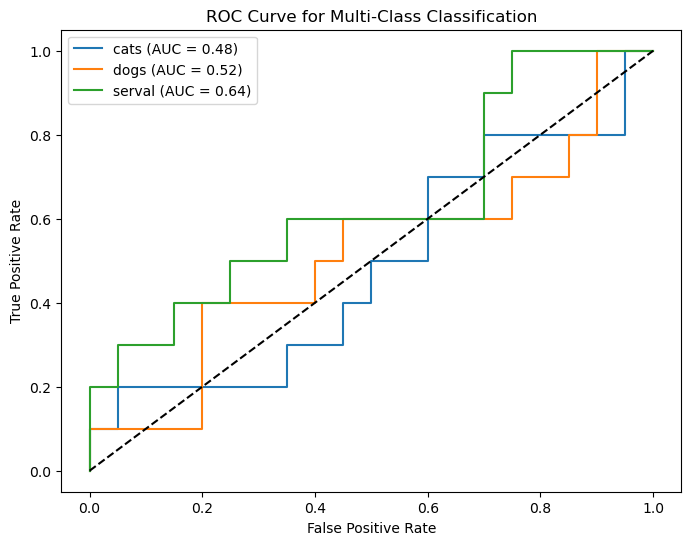

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Select device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define dataset directories
data_dir = "MY_DATASET_EXP5"  # Change this to your dataset path
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Define transformations for Data Augmentation
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=transform_train)
test_dataset = ImageFolder(root=test_dir, transform=transform_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)

# Get number of classes
num_classes = len(train_dataset.classes)
class_names = train_dataset.classes
print(f"Classes: {class_names}")

# Define the CNN model for 256x256 images
class CNN_256(nn.Module):
    def __init__(self, num_classes):
        super(CNN_256, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)  # Adjusted for 256x256 input
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.bn1(self.conv1(x))))
        x = self.pool(nn.ReLU()(self.bn2(self.conv2(x))))
        x = self.pool(nn.ReLU()(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(nn.ReLU()(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialize model
model = CNN_256(num_classes=num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce LR every 10 epochs

# Training loop
num_epochs = 200  # Increased epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    scheduler.step()  # Adjust learning rate

    train_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

# Testing loop
model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities

        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

test_accuracy = 100 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
print(f"\nTest Accuracy: {test_accuracy:.2f}%")

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))

# Convert labels to one-hot encoding for ROC curve
all_labels_bin = label_binarize(all_labels, classes=list(range(num_classes)))
all_probs = np.array(all_probs)

# Plot ROC Curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Classification")
plt.legend()
plt.show()

In [2]:
len(all_labels), len(all_preds)

(30, 30)

In [3]:
conf_matrix

array([[4, 2, 4],
       [5, 1, 4],
       [3, 1, 6]], dtype=int64)